# Benchmarks

## Initialize

In [1]:
#library(Rmisc)
library(dtplyr)
library(tidyverse)
library(glue)
library(arrow)
library(patchwork)
library(data.table)
library("jsonlite")
library(ggthemes)

Warning message:
“package ‘dtplyr’ was built under R version 4.0.3”
Warning message:
“package ‘tidyverse’ was built under R version 4.0.3”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

Warning message:
“package ‘ggplot2’ was built under R version 4.0.5”
Warning message:
“package ‘tibble’ was built under R version 4.0.5”
Warning message:
“package ‘tidyr’ was built under R version 4.0.5”
Warning message:
“package ‘readr’ was built under R version 4.0.5”
Warning message:
“package ‘purrr’ was built under R version 4.0.3”
Warning message:
“package ‘dplyr’ was built under R version 4.0.5”
Warning message:
“package ‘stringr’ was built under R version 4.0.5”
Warning message:
“package ‘forcats’ was built under R version 4.0.3”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::f

In [2]:
if (grepl("sc", Sys.info()[["nodename"]], fixed=TRUE)) {
    base_path = "/sc-projects/sc-proj-ukb-cvd"
} else {
    base_path = "/data/analysis/ag-reils/ag-reils-shared/cardioRS"}
print(base_path)

project_label = "22_retina_phewas"
project_path = glue("{base_path}/results/projects/{project_label}")
figure_path = glue("{project_path}/figures")
output_path = glue("{project_path}/data")

experiment = '221108'
experiment_path = glue("{output_path}/{experiment}")

[1] "/sc-projects/sc-proj-ukb-cvd"


In [3]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major.y=element_line()))

In [4]:
colors_dict = read_json("colors.json")
color_map <- c(
    "Age+Sex" = colors_dict$pastel$red$mid,
    "Retina" = colors_dict$pastel$red$mid,
    "Age+Sex+Retina" = colors_dict$pastel$red$mid,
    'MultiTaskSurvivalTraining_None_InceptionResnetV2+MLP_Identity' = colors_dict$pastel$red$mid
    #"Identity(AgeSex)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(Records)+MLP" = colors_dict$pastel$red$mid,
    #"Identity(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid,
    #"GNN(AgeSex+Records)+MLP" = colors_dict$pastel$red$mid
)

In [5]:
endpoint_defs = arrow::read_feather(glue("{output_path}/phecode_defs_220306.feather")) %>% arrange(endpoint)

In [6]:
endpoint_map = endpoint_defs$phecode_string
names(endpoint_map) =  endpoint_defs$endpoint
endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint

In [7]:
endpoint_selection = c(
    # generally very important
    "phecode_202", # Diabetes mellitus
    "phecode_404", # Ischemic heart disease
    "phecode_404-1", # Myocardial infarction [Heart attack]
    "phecode_431-11", # Cerebral infarction [Ischemic stroke]
    "phecode_424", # Heart failure
    "OMOP_4306655", # All-Cause Death
    # also generally important and relevant
    #"phecode_440-3", # Pulmonary embolism
    #"phecode_468-1",	#Viral pneumonia
    "phecode_401",	#Hypertension"
    "phecode_460-2",	#Acute lower respiratory infection
    "phecode_468", # Pneumonia
    "phecode_474", # Chronic obstructive pulmonary disease [COPD]
    "phecode_542", # Chronic liver disease and sequelae
    "phecode_583", # Chronic kidney disease
    "phecode_328", # Dementias and cerebral degeneration
    
    
    # generally important and fun to check
    "phecode_164", # Anemia
   # "phecode_726-1", # Osteoporosis
    "phecode_286-2", #	Major depressive disorder
    "phecode_103", # Malignant neoplasm of the skin
    "phecode_101", # Malignant neoplasm of the digestive organs
    #"phecode_665", # Psoriasis
    "phecode_121", # Leukemia
    "phecode_705-1", # Rheumatoid arthritis
    
    
    # important for eye
    "phecode_371", # Cataract
   # "phecode_374-3", # Retinal vascular changes and occlusions
    "phecode_374-42", # Diabetic retinopathy
    "phecode_374-5", # Macular degeneration
    "phecode_375-1" # Glaucoma
    #"phecode_388" # Blindness and low vision
)

endpoints_common = c(
   'phecode_164', #Anemia
 'phecode_705-1', #Rheumatoid arthritis
 'phecode_328', #Dementias and cerebral degeneration
 'phecode_328-1', #Alzheimer's disease
 'phecode_401', #Hypertension
 'phecode_202', #Diabetes mellitus
 'phecode_416-21', #Atrial fibrillation
 'phecode_404-1', #Myocardial infarction [Heart attack]
 'phecode_424', #Heart failure
 'phecode_468', #Pneumonia
 'phecode_474', #Chronic obstructive pulmonary disease [COPD]
 'phecode_583', #Chronic kidney disease
 'OMOP_4306655' #All-Cause Death
    )
    
endpoints_cardio = c(
    'phecode_438-11',   #  "Abdominal aortic aneurysm",
    'phecode_440-3',#  "Pulmonary embolism", # intervention
    'phecode_413-21',#  "Aortic stenosis", # intervention
    'phecode_400'#  "Rheumatic fever and chronic rheumatic heart diseases",	
)

endpoints_eye= c(
    'phecode_374-5', #Macular degeneration
 'phecode_374-51', #Age-related macular degeneration
 'phecode_374-42', #Diabetic retinopathy
 'phecode_371', #Cataract
 'phecode_388', #Blindness and low vision
 'phecode_367-5', #Uveitis
 'phecode_389-1' #Ocular pain
)

In [8]:
endpoint_defs = endpoint_defs %>% 
    mutate(name = phecode_string) %>%
    mutate(name = 
           case_when( 
               phecode_string == "Myocardial infarction [Heart attack]"~"Myocardial infarction",
               phecode_string == "Cerebral infarction [Ischemic stroke]"~"Ischemic stroke",
               phecode_string == "Chronic obstructive pulmonary disease [COPD]"~"Chronic obstructive pulmonary disease",
               phecode_string == "Mitral valve insufficiency"~"Mitral insufficiency",
               phecode_string == "Parkinson's disease (Primary)"~"Parkinson's disease",
               phecode_string == "Suicide ideation and attempt or self harm"~"Suicide attempt",
               phecode_string == "Ischemic heart disease"~"Coronary heart disease",
               phecode_string == "Chronic kidney disease"~"Chronic kidney disease",
               phecode_string == "Rheumatic fever and chronic rheumatic heart diseases"~"Rheumatic heart disease",
               phecode_string == "Abdominal aortic aneurysm"~"Abdominal aortic aneurysm",
                  TRUE ~ name)
           )
            
endpoint_map = endpoint_defs$name
names(endpoint_map) =  endpoint_defs$endpoint
#endpoint_order = (endpoint_defs %>% arrange(as.numeric(phecode)))$endpoint
endpoint_order = endpoint_selection

## Load data

# Load Benchmarks

In [9]:
#today = substr(Sys.time(), 0, 10) # YYYY-MM-DD
today = '221109'

In [10]:
#name = glue("benchmark_cindex_agesexcoxph_{today}")
name = glue("benchmarks_cindex_{today}")
crop_ratio = "0.66" # 0.3, 0.5, 0.8
benchmark_endpoints = arrow::read_feather(glue("{experiment_path}/{name}.feather")) %>% left_join(endpoint_defs) 

Joining, by = "endpoint"


In [11]:
benchmark_endpoints = benchmark_endpoints %>%
    filter(model == glue("ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio{crop_ratio}"))

In [12]:
benchmark_endpoints %>% group_by(endpoint, score)  %>% summarise(cindex=mean(cindex)) %>% group_by(score) %>% summarise(mean(cindex)) %>% arrange(`mean(cindex)`)

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


score,mean(cindex)
<chr>,<dbl>
Age+Sex,0.6042527
Retina,0.6053503
Age+Sex+Retina,0.6176102


In [13]:
endpoints_sorted = (benchmark_endpoints %>% 
    filter(score == "Age+Sex+Retina") %>% 
    group_by(endpoint, score) %>% 
    summarise(cindex=mean(cindex, na.rm=TRUE)) %>% 
    arrange(cindex) %>% ungroup())$endpoint

`summarise()` has grouped output by 'endpoint'. You can override using the
`.groups` argument.


In [14]:
categories_sorted = (endpoint_defs %>% distinct(phecode_category))$phecode_category

## delta c-idx with negative values

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can
override using the `.groups` argument.


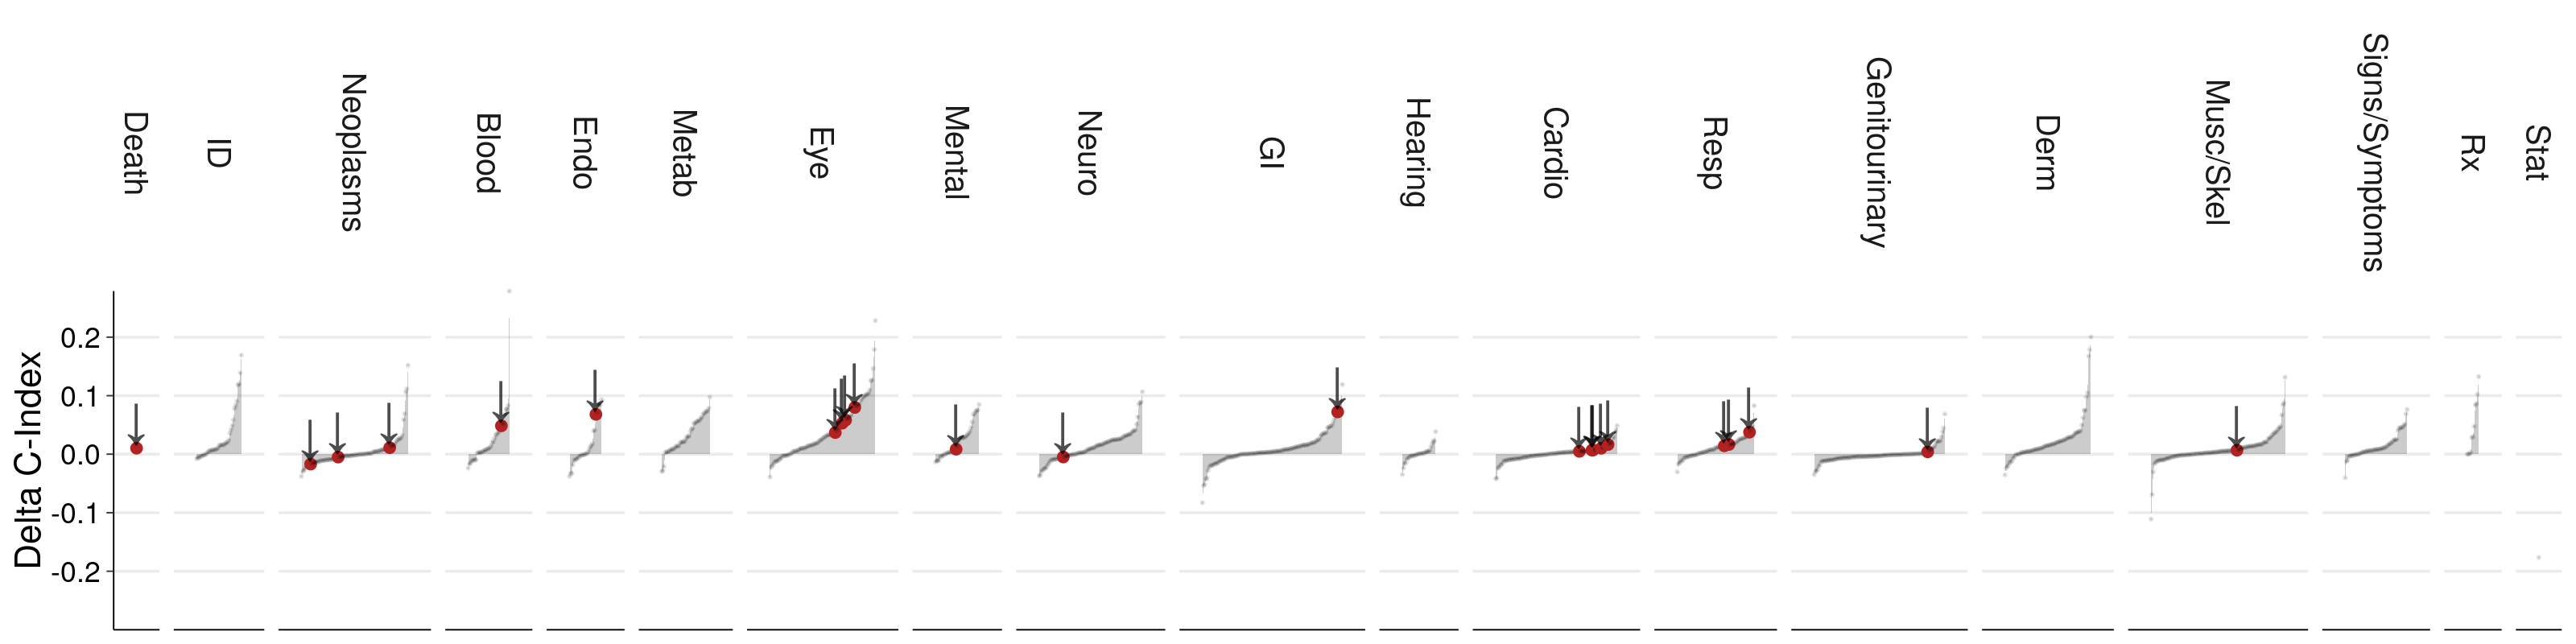

In [15]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp %>% arrange(delta))$endpoint

temp = temp %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) %>% mutate(endpoint = row_number())

ggplot(temp) +
    geom_ribbon(aes(x=endpoint, ymin=0, ymax=delta), fill="black", alpha=0.2)+
    geom_point(aes(x=endpoint, y=delta, color=highlight, size=highlight, alpha=highlight)) +
    geom_text(data=temp %>% filter(highlight=="YES"), aes(x=endpoint, y=delta+0.045, label="↓"), color="black", size=5, alpha=0.7) +
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    labs(x="Endpoints", y=glue("Delta C-Index"))+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    scale_alpha_manual(values=c("NO"=0.1, "YES"=1))+
    scale_size_manual(values=c("NO"=0.01, "YES"=1))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    #coord_polar() +
    coord_cartesian(ylim=c(-0.3, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=20))+
    facet_grid(~phecode_category, scales="free_x", space="free_x")+#, switch=TRUE)+
    #facet_grid2(~phecode_category, scales = "free", independent = "all") + 
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major=element_blank(), 
         strip.text = element_text(angle=270)) + 
    theme(legend.position="none") 
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

## delta c-idx with positive values (negative set to 0)

`summarise()` has grouped output by 'endpoint', 'phecode_string'. You can
override using the `.groups` argument.


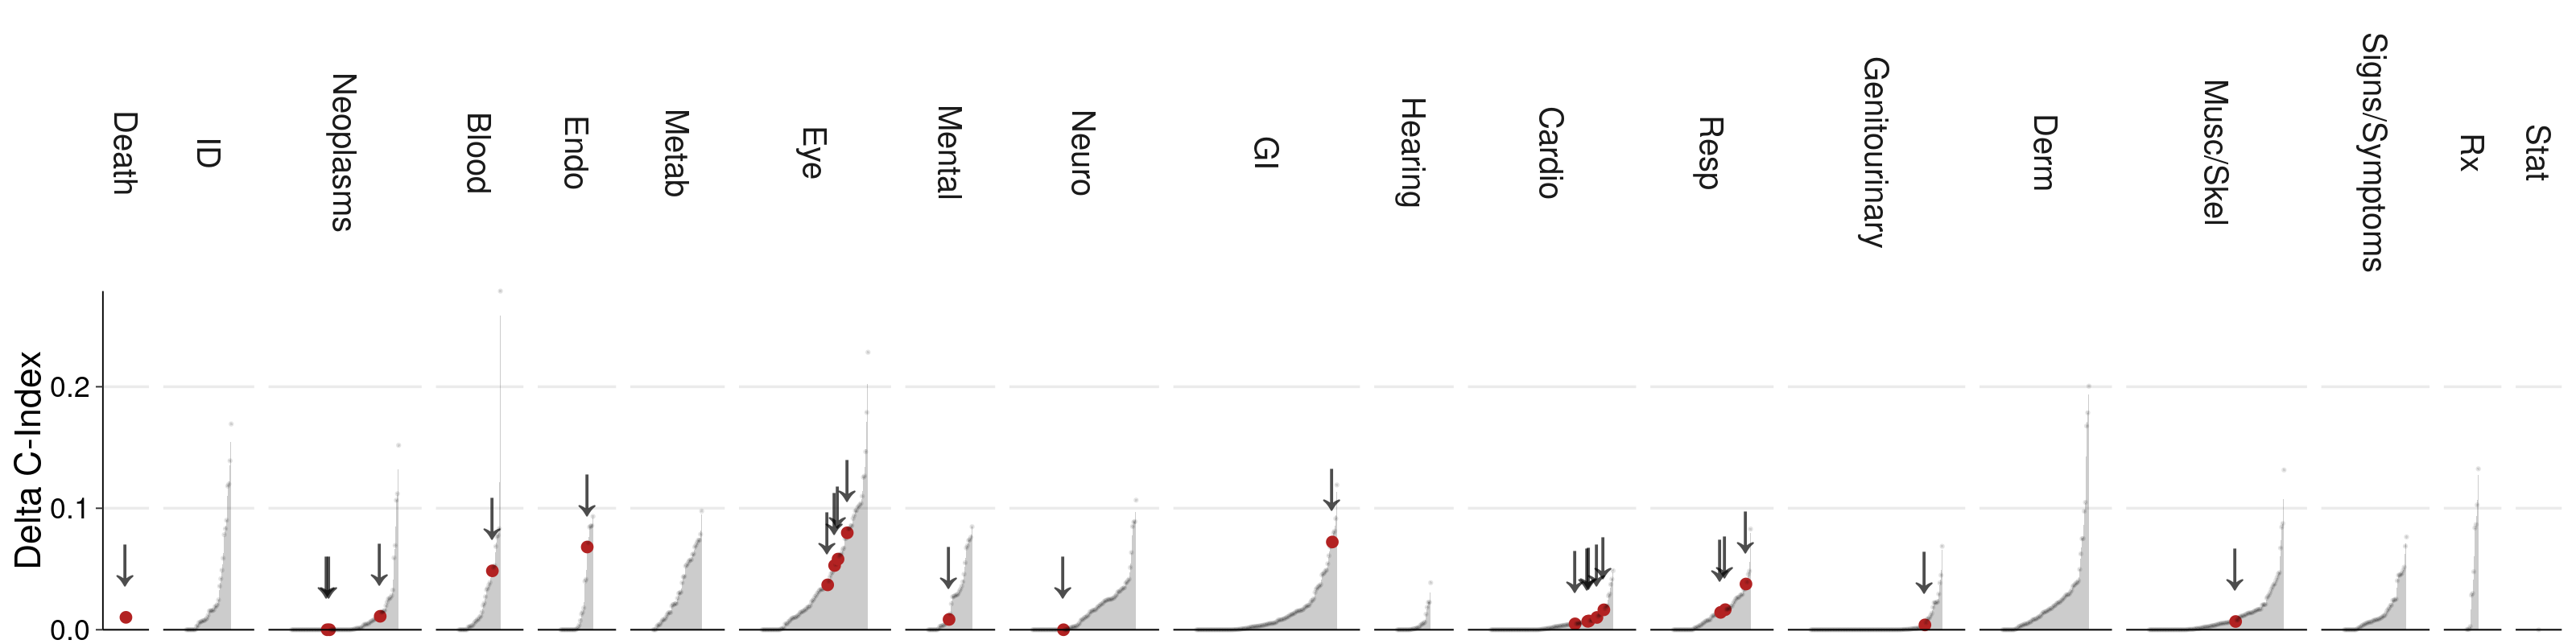

In [16]:
plot_width = 10; plot_height=2.5; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp_pos = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`)

index <- temp_pos$delta < 0
temp_pos$delta[index] <- 0.

temp_pos = temp_pos %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    summarise(delta = median(delta)) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted))

endpoint_order = (temp_pos %>% arrange(delta))$endpoint

temp_pos = temp_pos %>% mutate(endpoint = factor(endpoint, levels=endpoint_order)) %>% ungroup() %>% arrange(endpoint) %>% group_by(phecode_category) %>% mutate(endpoint = row_number())

ggplot(temp_pos) +
    geom_ribbon(aes(x=endpoint, ymin=0, ymax=delta), fill="black", alpha=0.2)+
    geom_point(aes(x=endpoint, y=delta, color=highlight, size=highlight, alpha=highlight)) +
    geom_text(data=temp_pos %>% filter(highlight=="YES"), aes(x=endpoint, y=delta+0.045, label="↓"), color="black", size=5, alpha=0.7) +
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    labs(x="Endpoints", y=glue("Delta C-Index"))+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    scale_alpha_manual(values=c("NO"=0.1, "YES"=1))+
    scale_size_manual(values=c("NO"=0.01, "YES"=1))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    #coord_polar() +
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=20))+
    facet_grid(~phecode_category, scales="free_x", space="free_x")+#, switch=TRUE)+
    #facet_grid2(~phecode_category, scales = "free", independent = "all") + 
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
        panel.grid.major=element_blank(), 
         strip.text = element_text(angle=270)) + 
    theme(legend.position="none") 
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)

In [17]:
plot_width = 8.25; plot_height=2; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)

scores_plot = c("Retina", "Age+Sex", "Age+Sex+Retina")#, "AgeSexRetina")

temp = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    ungroup() %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #mutate(delta_int = `Age+Sex+Retina`-`Age+Sex+Retina`) %>%
    mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    mutate(endpoint = fct_reorder(endpoint, delta)) %>%
    mutate(highlight = case_when(endpoint %in% endpoint_selection ~ "YES", TRUE ~ "NO")) %>%# %>% filter(endpoint %in% endpoint_sample)
    mutate(phecode_category = factor(phecode_category, levels=categories_sorted)) %>%
    filter(endpoint %in% endpoint_selection)
    #%>%
    #summarise(cindex = mean(cindex)) 
temp %>% head()

endpoint,model,iteration,time,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name,Age+Sex,Retina,Age+Sex+Retina,id,delta,pos,highlight
<fct>,<chr>,<int>,<int>,<chr>,<chr>,<fct>,<chr>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>,<chr>
OMOP_4306655,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death,0.7118385,0.7142370,0.7230579,1,0.011219349,pos,YES
phecode_101,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,101,Malignant neoplasm of the digestive organs,Neoplasms,Both,0,101,0,Malignant neoplasm of the digestive organs,0.6725117,0.6569561,0.6672878,43,-0.005223876,neg,YES
phecode_103,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,103,Malignant neoplasm of the skin,Neoplasms,Both,0,103,0,Malignant neoplasm of the skin,0.6513287,0.6463095,0.6631236,53,0.011794879,pos,YES
phecode_121,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,121,Leukemia,Neoplasms,Both,0,121,0,Leukemia,0.6738304,0.6565240,0.6597748,88,-0.014055586,neg,YES
phecode_164,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,164,Anemia,Blood,Both,0,164,0,Anemia,0.5873684,0.6295590,0.6304393,140,0.043070948,pos,YES
phecode_202,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,202,Diabetes mellitus,Endo,Both,0,202,0,Diabetes mellitus,0.5883551,0.6542227,0.6608138,186,0.072458677,pos,YES


In [18]:
library(ggdist)

Warning message:
“package ‘ggdist’ was built under R version 4.0.5”


In [19]:
base_size = 8
title_size = 10
facet_size = 9
geom_text_size=3
theme_set(theme_classic(base_size = base_size) + 
          theme(strip.background = element_blank(), plot.title=element_text(size=title_size, hjust=0), 
                strip.text.x = element_text(size = facet_size),axis.title=element_text(size=10), axis.text=element_text(size=8, color="black"),
                legend.position="bottom", axis.line = element_line(size = 0.2), axis.ticks=element_line(size=0.2), panel.grid.major=element_line()))

In [20]:
endpoint_selection 

[1] "phecode_202"    "phecode_404"    "phecode_404-1"  "phecode_431-11"
 [5] "phecode_424"    "OMOP_4306655"   "phecode_401"    "phecode_460-2" 
 [9] "phecode_468"    "phecode_474"    "phecode_542"    "phecode_583"   
[13] "phecode_328"    "phecode_164"    "phecode_286-2"  "phecode_103"   
[17] "phecode_101"    "phecode_121"    "phecode_705-1"  "phecode_371"   
[21] "phecode_374-42" "phecode_374-5"  "phecode_375-1"

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



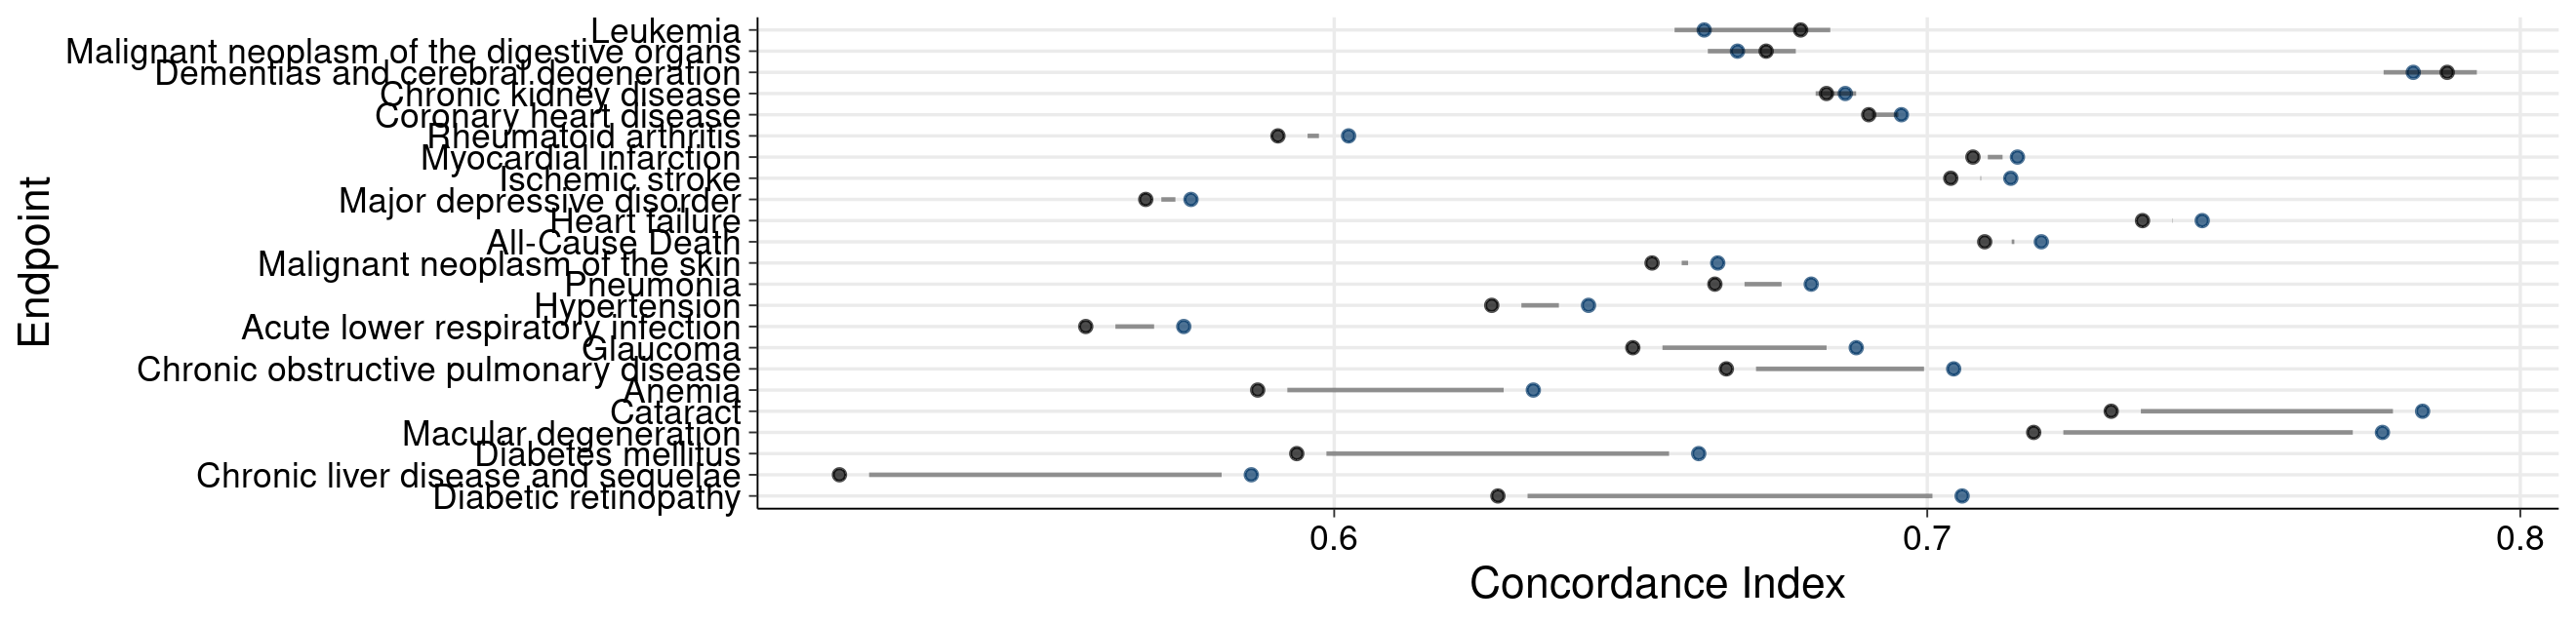

In [21]:
# temp %>% filter(endpoint %in% endpoint_selection) %>%
#     group_by(endpoint) %>%
#     summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`)) %>%
#     mutate(endpoint, recode_factor(endpoint, !!!endpoint_map))

abs = ggplot(temp %>% 
             filter(endpoint %in% endpoint_selection) %>%
             group_by(endpoint) %>%
             summarise(m_asm=median(`Age+Sex+Retina`), m_as=median(`Age+Sex`))
                ) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Concordance Index", x="Endpoint")+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex`), size=1, color="black", alpha=0.3)+
    #stat_pointinterval(aes(x=fct_rev(endpoint), y=`Age+Sex+Retina`), size=1, color="#023768", alpha=0.5)+
    geom_point(aes(x=fct_rev(endpoint), y=m_as), size=1, color="black", alpha=0.7)+
    geom_point(aes(x=fct_rev(endpoint), y=m_asm), size=1, color="#023768", alpha=0.7)+
    geom_segment(aes(x=endpoint, xend=endpoint, y=m_as+0.005, yend=m_asm-0.005), alpha=0.4)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_x_discrete(labels=endpoint_map) +
    #scale_x_discrete(labels=function(endpoint_map) formatC(endpoint_map, width=5)) +
    #scale_y_continuous(expand=c(0, 0))+
    #theme(axis.title.x=element_blank(),
     #   axis.text.x=element_blank(),
      #  axis.ticks.x=element_blank(),
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1)
abs 

Coordinate system already present. Adding new coordinate system, which will replace the existing one.



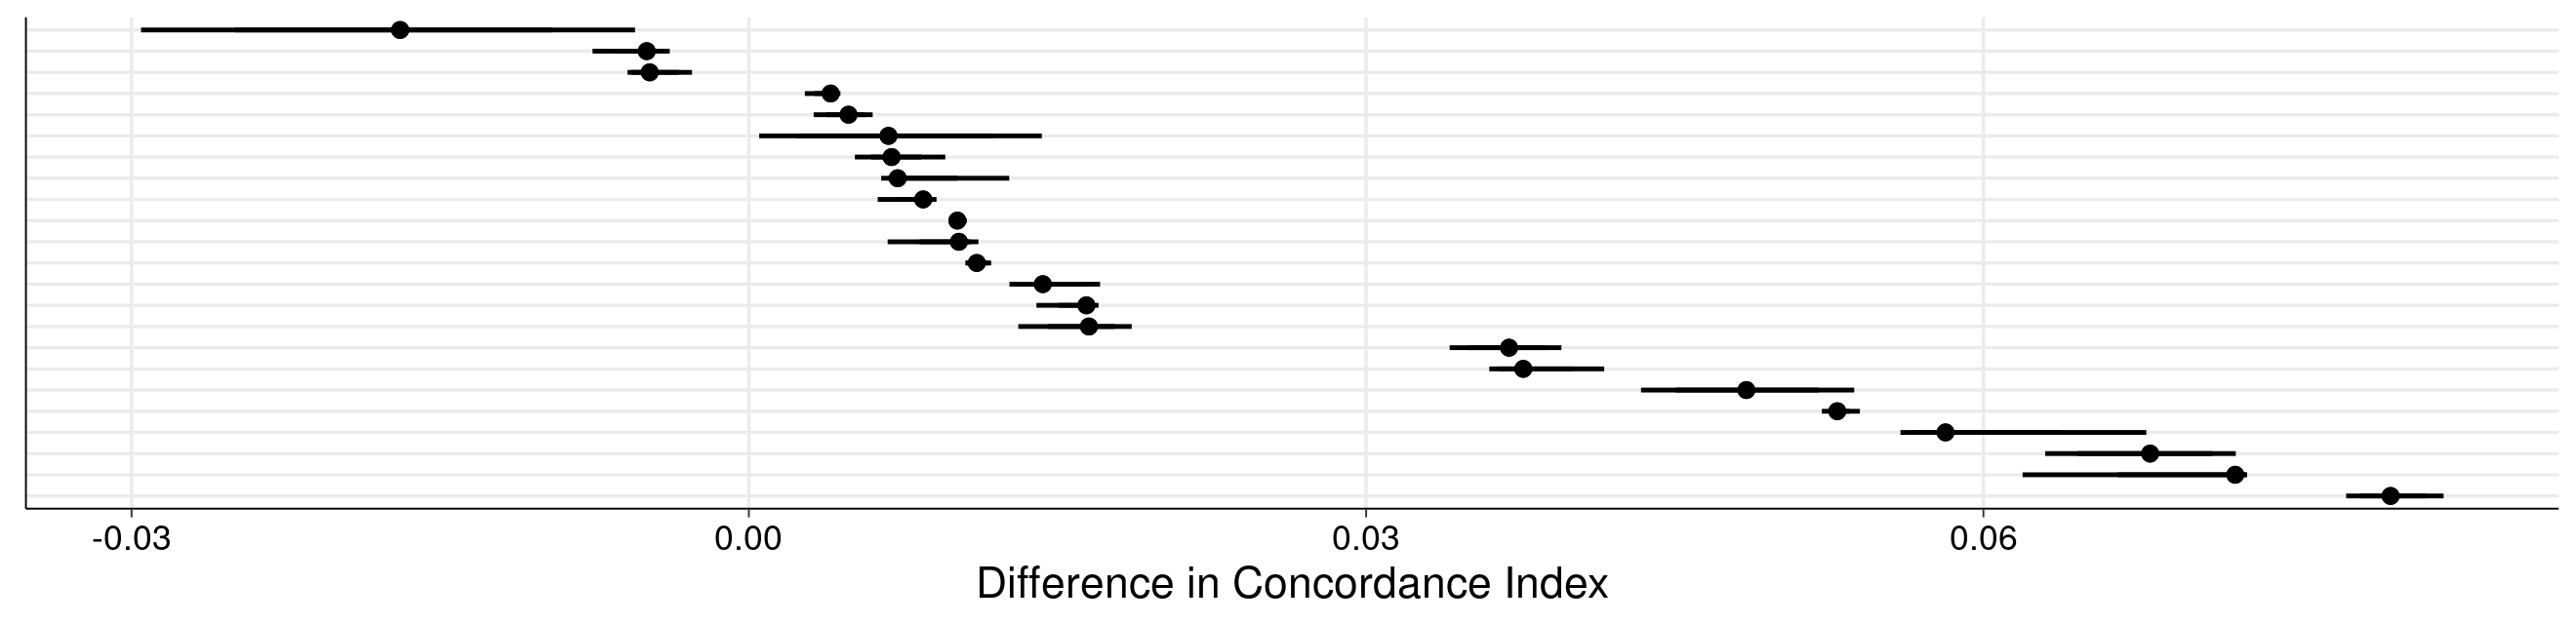

In [22]:
rel = ggplot(temp) + 
    #geom_violin(aes(x=fct_rev(endpoint), y=delta), size=0.5) +
    labs(y="Difference in Concordance Index")+
    stat_pointinterval(aes(x=fct_rev(endpoint), y=delta), size=0.5)+
    #geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    #scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    #scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    #scale_y_continuous(expand=c(0, 0))+
    theme(axis.title.y=element_blank(),
        axis.text.y=element_blank(),
       axis.ticks.y=element_blank()) + 
    coord_flip()+
     theme(strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
rel    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+Retina`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

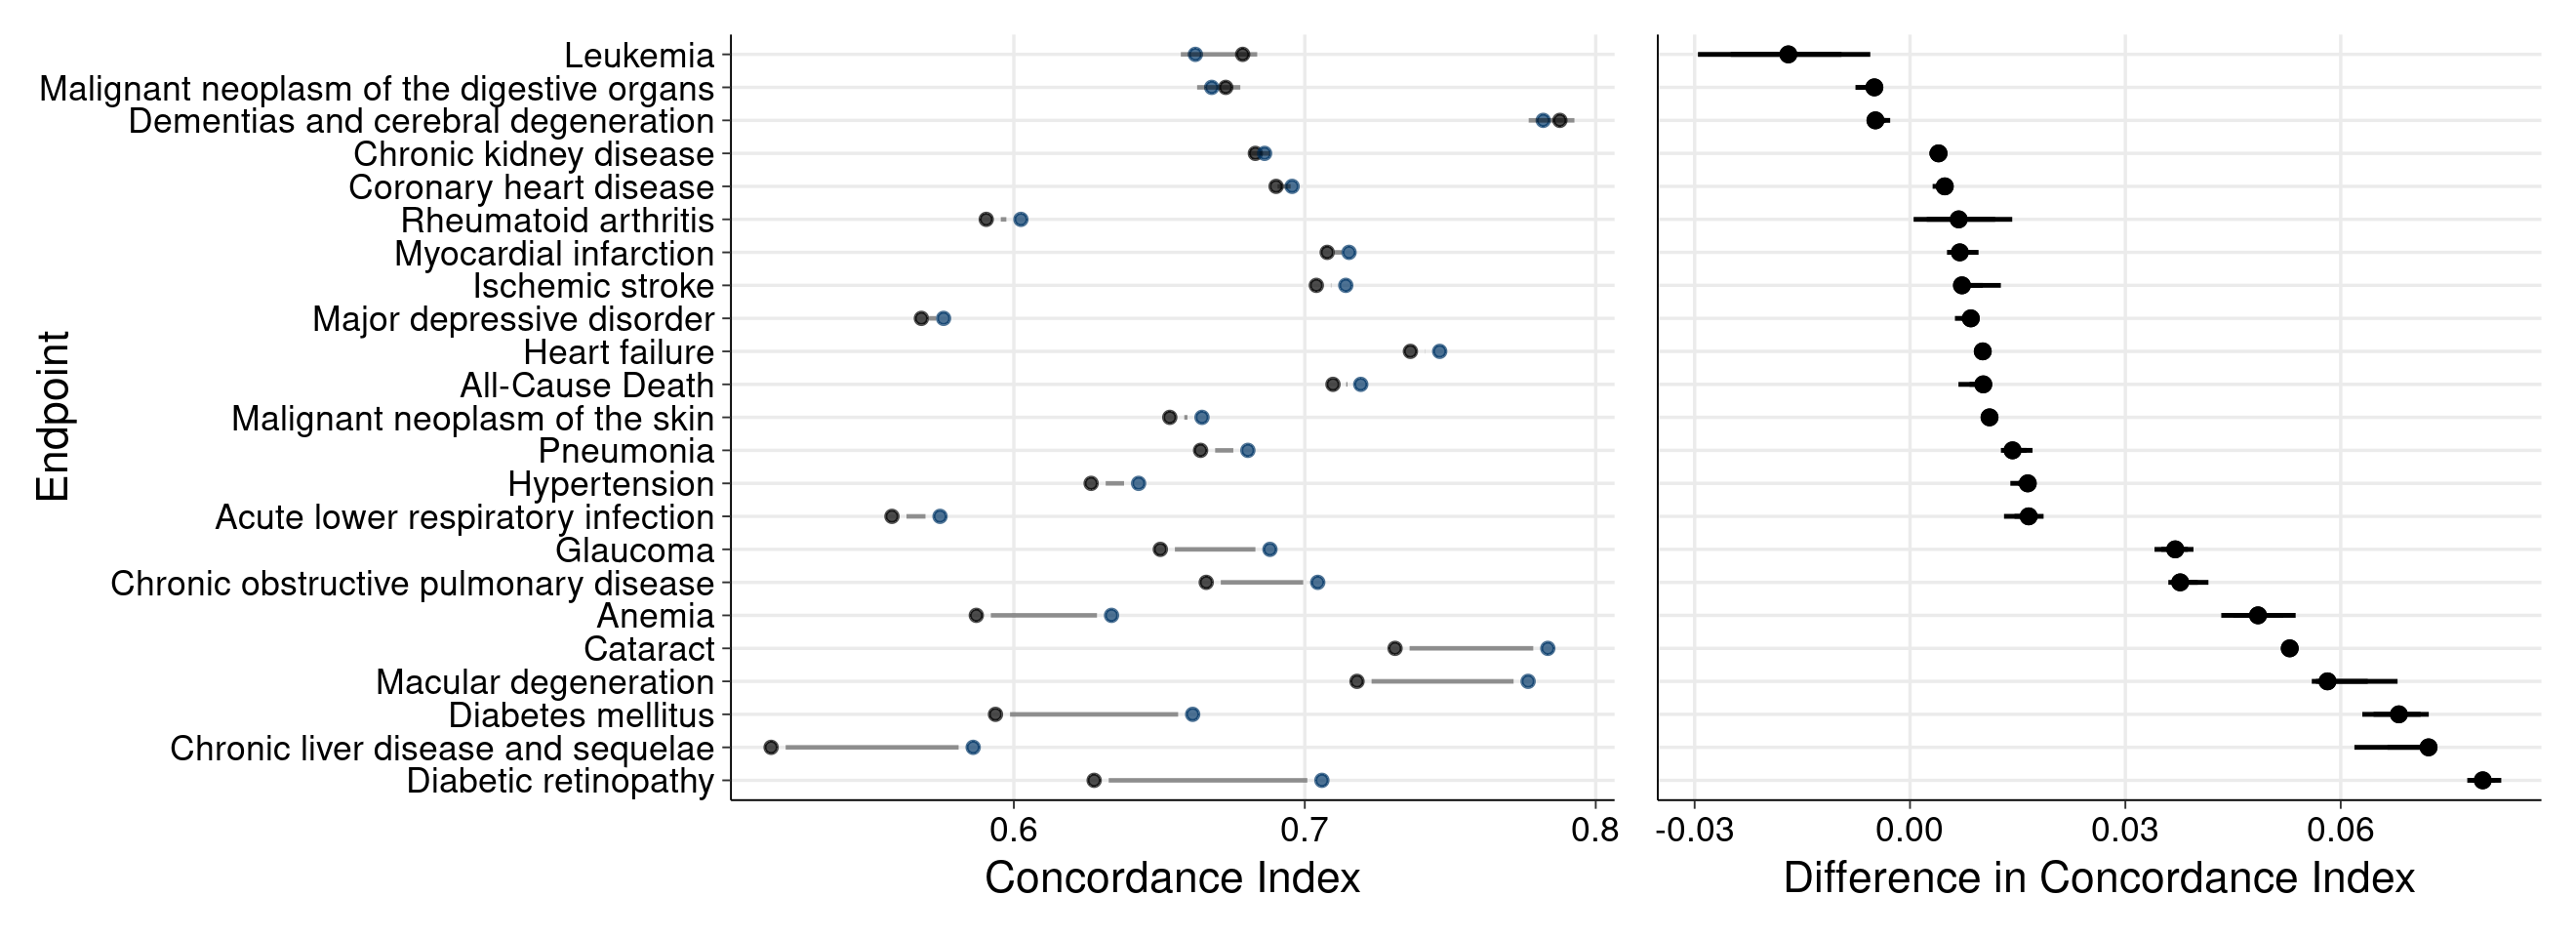

In [23]:
plot_width = 8.25; plot_height=3; plot_res = 320
options(repr.plot.width = plot_width, repr.plot.height = plot_height, repr.plot.res=plot_res)
abs|rel

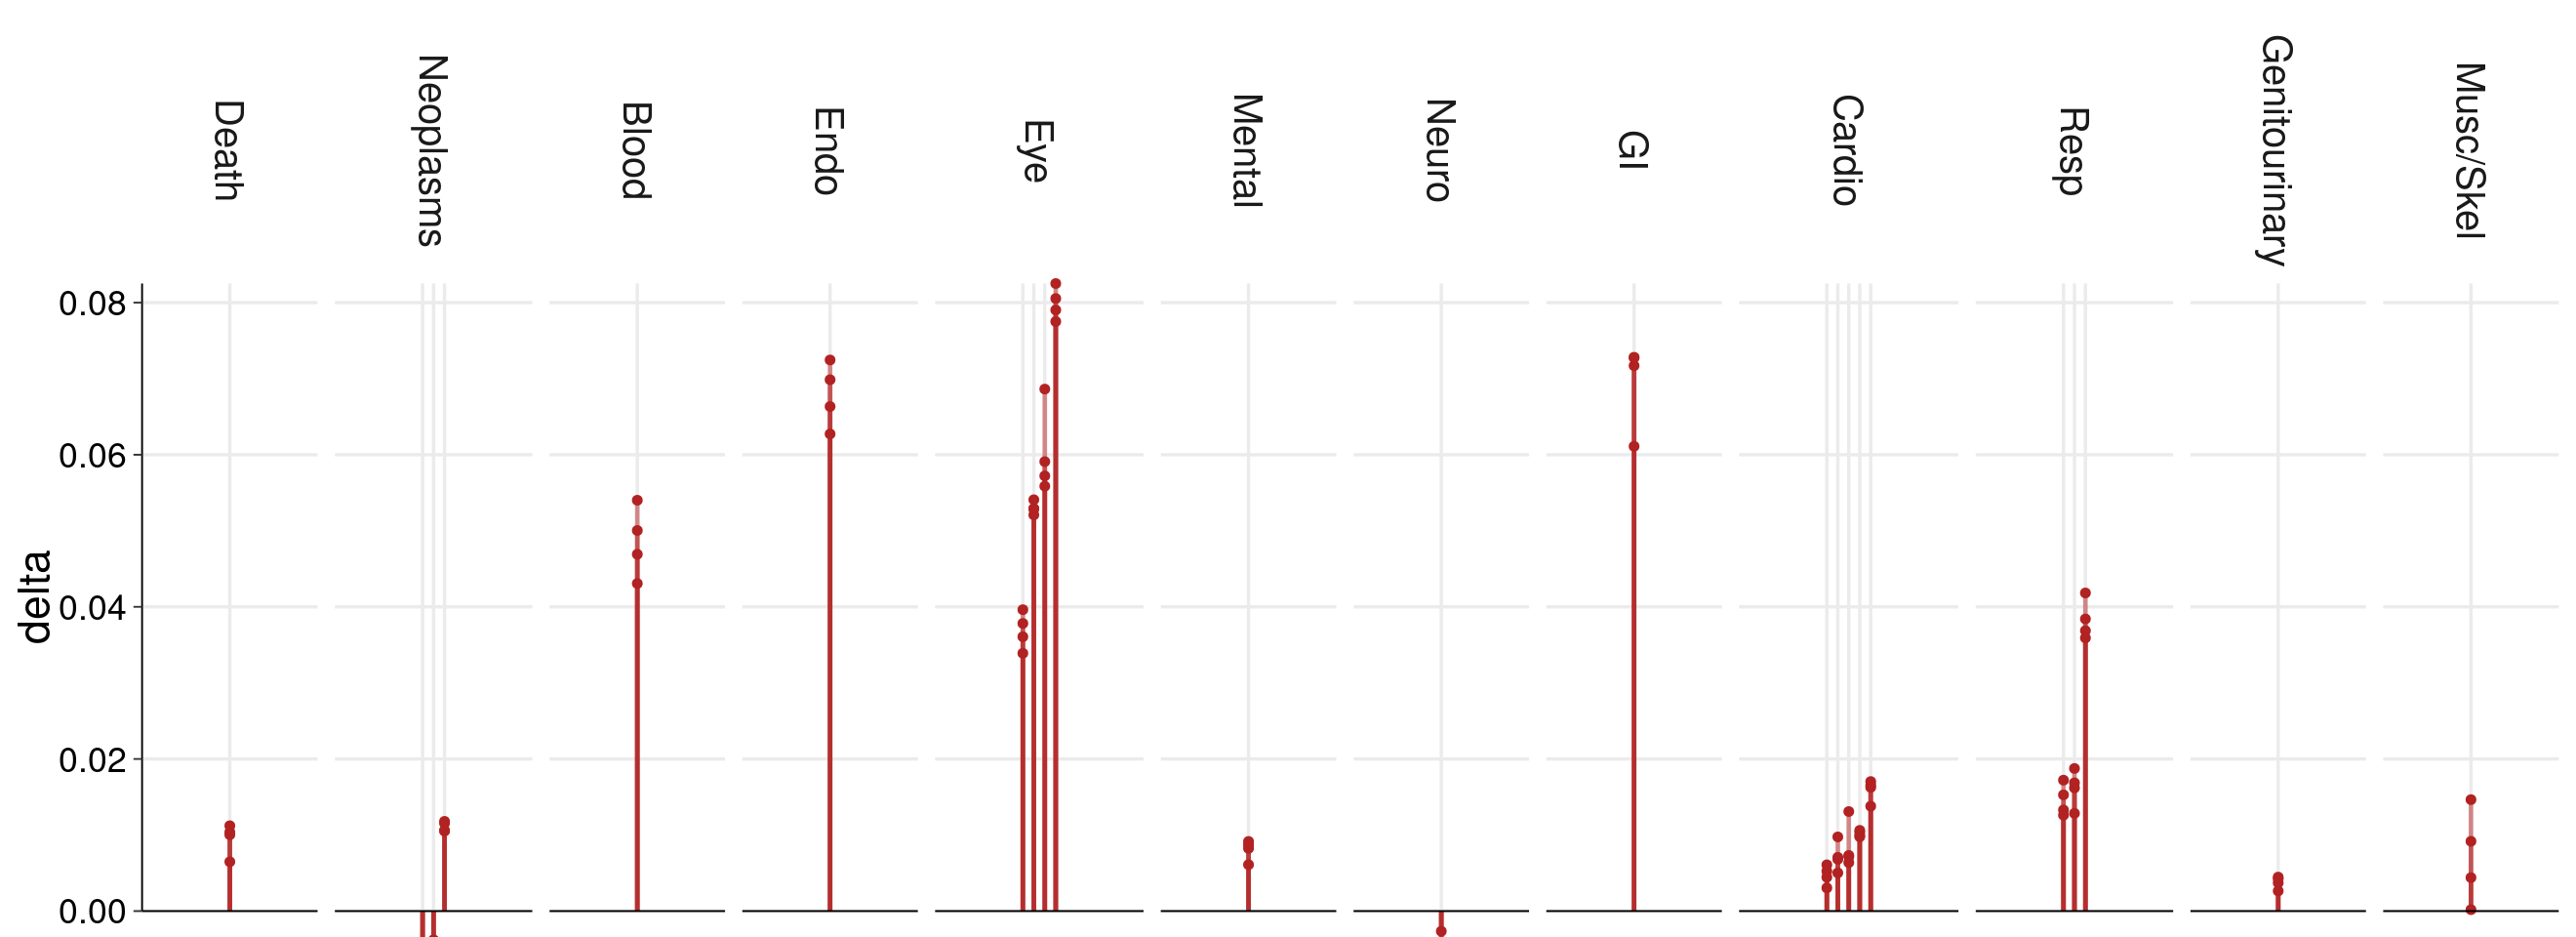

In [24]:
ggplot(temp) + 
    geom_point(aes(x=endpoint, y=delta, color=highlight), size=0.5) +
    geom_segment(aes(x=endpoint, xend=endpoint, y=0, yend=delta, color=highlight, size=highlight), alpha=0.5)+#+
    scale_color_manual(values=c("NO"="black", "YES"="firebrick"))+
    #scale_alpha_manual(values=c("NO"=0.3, "YES"=0.7))+
    scale_size_manual(values=c("NO"=0.1, "YES"=0.5))+
    #scale_colour_manual(values = c("pos"="forestgreen", "neg" = "firebrick")) + 
    coord_cartesian(ylim=c(0, NA), clip = "off")+
    scale_y_continuous(expand=c(0, 0))+
    scale_x_discrete(expand=expansion(add=8))+
    facet_grid(~phecode_category, scale="free_x", space="free_x")+#, switch=TRUE)+
    theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank(),
     strip.text = element_text(angle=270)) + 
    theme(legend.position="none")
    
    #geom_ribbon(aes(x=id, ymin=AgeSex, ymax=`Age+Sex+MedicalHistory`), fill="red", alpha=0.2)
#geom_violin(size=0.1) 

In [25]:
library(ggdist)

In [26]:
table_2_pre = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    group_by(endpoint, phecode_string, phecode_category) %>%
    median_qi(delta)
    #mutate(posdelta = case_when(delta>=0 ~ "pos", delta < 0 ~"neg"))
#table_2_pre %>% head()
print(nrow(table_2_pre))

cat("nrows with positive lower q of delta:", nrow(table_2_pre %>% filter(.lower > 0)))
cat("\nnrows with negative lower q of delta:", nrow(table_2_pre %>% filter(.lower <= 0)))
cat("\nnrows with positive delta:", nrow(table_2_pre %>% filter(delta > 0)))
cat("\nnrows with negative delta:", nrow(table_2_pre %>% filter(delta <= 0)))

[1] 1171
nrows with positive lower q of delta: 616
nrows with negative lower q of delta: 555
nrows with positive delta: 763
nrows with negative delta: 408

In [27]:
table_2_significant = table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint)

In [28]:
options(repr.matrix.max.rows=1500, repr.matrix.max.cols=200)


table_2_significant %>% arrange(desc(delta))

endpoint,phecode_string,phecode_category,delta,.lower,.upper,.width,.point,.interval
<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
phecode_165,Hemoglobinopathies,Blood,0.2787211660,2.530873e-01,0.2960326689,0.95,median,qi
phecode_387-2,Myopia,Eye,0.2283584851,2.178444e-01,0.2329520597,0.95,median,qi
phecode_688-1,Sarcoidosis,Derm,0.2004851268,1.816888e-01,0.2137273820,0.95,median,qi
phecode_373,Noninflammatory disorders of choroid,Eye,0.1788697681,1.652643e-01,0.2280678324,0.95,median,qi
phecode_665-2,Psoriatic arthropathy,Derm,0.1785917794,1.706037e-01,0.2009341042,0.95,median,qi
phecode_005,Mycobacteria,ID,0.1693581980,1.621491e-01,0.2084348993,0.95,median,qi
phecode_665-3,Other psoriasis,Derm,0.1676815017,1.201907e-01,0.2027343862,0.95,median,qi
phecode_139-3,Benign neoplasm of other connective and soft tissue,Neoplasms,0.1518443026,1.459599e-01,0.1668504554,0.95,median,qi
phecode_377-5,Vitreous hemorrhage,Eye,0.1465310293,1.370438e-01,0.1603710348,0.95,median,qi


In [29]:
table_2_significant %>% group_by(phecode_category) %>% count() %>% mutate(freq=n/ 283)

phecode_category,n,freq
<chr>,<int>,<dbl>
Blood,23,0.081272085
Cardio,40,0.141342756
Death,1,0.003533569
Derm,57,0.201413428
Endo,11,0.038869258
Eye,68,0.240282686
Genitourinary,20,0.070671378
GI,66,0.233215548
Hearing,11,0.038869258


In [30]:
table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable2_SignificantEndpoints_CropRatio-{crop_ratio}.csv"))

In [31]:

table_2_pre %>%
    filter(delta > 0) %>%
    filter(.lower > 0) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable2_SignificantEndpoints_CropRatio-{crop_ratio}.csv"))

In [32]:
benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+Retina`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>% 
ungroup() %>%
    pivot_wider(names_from=type, values_from=cindex) %>%
select(phecode_string, `Age+Sex+Retina`, `Age+Sex`, delta) #%>% filter(delta>0) %>% arrange(desc(`Age+Sex+Retina`))


phecode_string,Age+Sex+Retina,Age+Sex,delta
<chr>,<dbl>,<dbl>,<dbl>
Transplated organ,NA,0.5558512,NA
Transplated organ,0.3931890,NA,NA
Transplated organ,NA,NA,-0.1765345761
Other signs and symptoms in breast,NA,0.4499098,NA
Other signs and symptoms in breast,0.4601489,NA,NA
Other signs and symptoms in breast,NA,NA,0.0135953504
Abscess or ulceration of vulva,NA,0.4020573,NA
Abscess or ulceration of vulva,0.4615512,NA,NA
Abscess or ulceration of vulva,NA,NA,0.0686747830


In [33]:
table_2 = benchmark_endpoints %>% 
    filter(score %in% scores_plot) %>% 
    mutate(score = factor(score, levels=scores_plot)) %>%
    mutate(endpoint = factor(endpoint, levels=endpoints_sorted)) %>%
    group_by(endpoint, score, phecode_string, phecode_category) %>%
    pivot_wider(names_from=score, values_from=cindex) %>% 
    mutate(id = row_number()) %>%
    mutate(delta = `Age+Sex+Retina`-`Age+Sex`) %>%
    #select(endpoint, iteration, phecode_string, phecode_category, sex, `Age+Sex`, `Age+Sex+Retina`, delta) %>%
    pivot_longer(all_of(c("Age+Sex", "Age+Sex+Retina", "delta")), names_to="type", values_to="cindex") %>%
    group_by(endpoint, phecode_string, phecode_category, type) %>%
    median_qi(cindex) %>%
    #ungroup() %>%
    mutate(agg = glue("{round(cindex, 3)} ({round(.lower, 3)}, {round(.upper, 3)})")) %>%
    ungroup() %>% select(endpoint, phecode_string, phecode_category, type, agg) %>%
    pivot_wider(names_from=type, values_from=agg)
    #mutate(pos = case_when(delta>=0 ~ "pos", delta < 0 ~"neg")) %>%
    #mutate(endpoint = fct_reorder(endpoint, delta))# %>% filter(endpoint %in% endpoint_sample)

In [34]:
table_2 %>% 
    select(all_of(c("endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint)

endpoint,phecode_string,Age+Sex,Age+Sex+Retina,delta
<fct>,<chr>,<glue>,<glue>,<glue>
phecode_121,Leukemia,"0.679 (0.667, 0.701)","0.662 (0.66, 0.671)","-0.017 (-0.03, -0.006)"
phecode_101,Malignant neoplasm of the digestive organs,"0.673 (0.672, 0.674)","0.668 (0.666, 0.669)","-0.005 (-0.008, -0.004)"
phecode_328,Dementias and cerebral degeneration,"0.788 (0.783, 0.801)","0.782 (0.779, 0.798)","-0.005 (-0.006, -0.003)"
phecode_583,Chronic kidney disease,"0.683 (0.676, 0.686)","0.686 (0.68, 0.69)","0.004 (0.003, 0.004)"
phecode_404,Ischemic heart disease,"0.69 (0.689, 0.693)","0.696 (0.694, 0.696)","0.005 (0.003, 0.006)"
phecode_705-1,Rheumatoid arthritis,"0.591 (0.586, 0.605)","0.602 (0.591, 0.606)","0.007 (0.001, 0.014)"
phecode_404-1,Myocardial infarction [Heart attack],"0.708 (0.707, 0.71)","0.715 (0.713, 0.717)","0.007 (0.005, 0.01)"
phecode_431-11,Cerebral infarction [Ischemic stroke],"0.704 (0.694, 0.709)","0.714 (0.701, 0.717)","0.007 (0.006, 0.013)"
phecode_286-2,Major depressive disorder,"0.568 (0.567, 0.572)","0.576 (0.575, 0.58)","0.008 (0.006, 0.009)"


In [35]:
options(pillar.print_max = Inf)
table_2 %>% 
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    #filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable1_DiscriminativePerformanceAll_CropRatio-{crop_ratio}.csv"))

In [36]:
options(pillar.print_max = Inf)
table_2 %>% 
    arrange(as.character(endpoint)) %>%
    select(all_of(c("phecode_category", "endpoint", "phecode_string", "Age+Sex", 'Age+Sex+Retina', "delta"))) %>%
    mutate(endpoint = factor(endpoint, levels = endpoint_order)) %>% 
    filter(endpoint %in% endpoint_selection) %>%
    arrange(endpoint) %>% 
    write_csv(glue("outputs/SupplTable1_DiscriminativePerformanceEndpointSelection_CropRatio-{crop_ratio}.csv"))

# SOME QC -> where do the NaNs come from?

In [37]:
benchmark_endpoints %>% head()

endpoint,score,model,iteration,time,cindex,phecode,phecode_string,phecode_category,sex,ICD10_only,phecode_top,leaf,name
<glue>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
OMOP_4306655,Age+Sex,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,0.7118385,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,0.7142370,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
OMOP_4306655,Age+Sex+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,0.7230579,4306655,All-Cause Death,Death,Both,NA,NA,NA,All-Cause Death
phecode_002,Age+Sex,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,0.5991144,002,Staphylococcus,ID,Both,0,002,0,Staphylococcus
phecode_002,Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,0.6531067,002,Staphylococcus,ID,Both,0,002,0,Staphylococcus
phecode_002,Age+Sex+Retina,ImageTraining_[]_ConvNeXt_MLPHead_predictions_cropratio0.66,2,10,0.6394815,002,Staphylococcus,ID,Both,0,002,0,Staphylococcus


In [38]:
tmp = benchmark_endpoints %>% select(endpoint, phecode_string, iteration, cindex)
tmp[!complete.cases(tmp),]

endpoint,phecode_string,iteration,cindex
<glue>,<chr>,<int>,<dbl>


In [39]:
tmp %>% select(phecode_string) %>% count()

n
<int>
14052
